In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import joblib
import scipy.stats as stats


In [3]:
#Upload all CSV files
from google.colab import files
uploaded = files.upload()  # Select all your CSVs at once


# ELECTRICITY MIX
electricity2021 = pd.read_csv('electricitymix-2021-hourly.csv')
electricity2022 = pd.read_csv('electricitymix-2022-hourly.csv')
electricity2023 = pd.read_csv('electricitymix-2023-hourly.csv')
electricity2024 = pd.read_csv('electricitymix-2024-hourly.csv')

electricity = pd.concat([electricity2021, electricity2022, electricity2023, electricity2024], ignore_index=True)

# SOLAR
solar2021 = pd.read_csv('zon-2021-uur-data.csv')
solar2022 = pd.read_csv('zon-2022-uur-data.csv')
solar2023 = pd.read_csv('zon-2023-uur-data.csv')
solar2024 = pd.read_csv('zon-2024-uur-data.csv')

solar = pd.concat([solar2021, solar2022, solar2023, solar2024], ignore_index=True)

# ONSHORE WIND
onwind2021 = pd.read_csv('onshorewind-2021-uur-data.csv')
onwind2022 = pd.read_csv('onshorewind-2022-uur-data.csv')
onwind2023 = pd.read_csv('onshorewind-2023-uur-data.csv')
onwind2024 = pd.read_csv('onshorewind-2024-uur-data.csv')

onshore_wind = pd.concat([onwind2021, onwind2022, onwind2023, onwind2024], ignore_index=True)

# OFFSHORE WIND
offwind2021 = pd.read_csv('offshorewind-2021-uur-data.csv')
offwind2022 = pd.read_csv('offshorewind-2022-uur-data.csv')
offwind2023 = pd.read_csv('offshorewind-2023-uur-data.csv')
offwind2024 = pd.read_csv('offshorewind-2024-uur-data.csv')

offshore_wind = pd.concat([offwind2021, offwind2022, offwind2023, offwind2024], ignore_index=True)

# BIOMASS
biomass2021 = pd.read_csv('biomassa-2021-uur-data.csv')
biomass2022 = pd.read_csv('biomassa-2022-uur-data.csv')
biomass2023 = pd.read_csv('biomassa-2023-uur-data.csv')
biomass2024 = pd.read_csv('biomassa-2024-uur-data.csv')

biomass = pd.concat([biomass2021, biomass2022, biomass2023, biomass2024], ignore_index=True)

# Load KNMI hourly data (skip the first 31 rows of metadata)
knmi_df = pd.read_csv(
    'uurgeg_260_2021-2030.txt',
    skiprows=31
)

# quick summaries
print("Electricity mix shape:", electricity.shape)
print("Solar shape:", solar.shape)
print("Onshore wind shape:", onshore_wind.shape)
print("Offshore wind shape:", offshore_wind.shape)
print("Biomass shape:", biomass.shape)

Saving uurgeg_260_2021-2030.txt to uurgeg_260_2021-2030.txt
Saving electricitymix-2024-hourly.csv to electricitymix-2024-hourly.csv
Saving biomassa-2024-uur-data.csv to biomassa-2024-uur-data.csv
Saving biomassa-2023-uur-data.csv to biomassa-2023-uur-data.csv
Saving biomassa-2022-uur-data.csv to biomassa-2022-uur-data.csv
Saving biomassa-2021-uur-data.csv to biomassa-2021-uur-data.csv
Saving offshorewind-2021-uur-data.csv to offshorewind-2021-uur-data.csv
Saving offshorewind-2022-uur-data.csv to offshorewind-2022-uur-data.csv
Saving offshorewind-2023-uur-data.csv to offshorewind-2023-uur-data.csv
Saving offshorewind-2024-uur-data.csv to offshorewind-2024-uur-data.csv
Saving onshorewind-2021-uur-data.csv to onshorewind-2021-uur-data.csv
Saving onshorewind-2022-uur-data.csv to onshorewind-2022-uur-data.csv
Saving onshorewind-2023-uur-data.csv to onshorewind-2023-uur-data.csv
Saving onshorewind-2024-uur-data.csv to onshorewind-2024-uur-data.csv
Saving zon-2021-uur-data.csv to zon-2021-uur

/tmp/ipython-input-3-4049604520.py:47: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  knmi_df = pd.read_csv(


In [4]:
# Strip whitespace from columns
knmi_df.columns = knmi_df.columns.str.strip()

# Fix 'HH' column and handle hour=24
knmi_df['HH'] = knmi_df['HH'].astype(int)
knmi_df['HH'] = knmi_df['HH'].replace(24, 0)
# Combine date and hour into datetime
knmi_df['datetime'] = pd.to_datetime(
    knmi_df['YYYYMMDD'].astype(str) + knmi_df['HH'].astype(str).str.zfill(2),
    format='%Y%m%d%H'
)
# Apply unit conversions
knmi_df['T'] = knmi_df['T'] / 10
knmi_df['FH'] = knmi_df['FH'] / 10
knmi_df['FF'] = knmi_df['FF'] / 10
knmi_df['Q'] = knmi_df['Q'] * 10
knmi_df['SQ'] = knmi_df['SQ'] / 10
knmi_df['RH'] = knmi_df['RH'] / 10

# Select relevant columns
weather_df = knmi_df[['datetime', 'T', 'FH','Q', 'SQ', 'RH', 'N']].copy()
weather_df.rename(columns={
    'T': 'temp',
    'FH': 'wind_speed',
    'Q': 'radiation',
    'SQ': 'sunshine',
    'RH': 'precipitation',
    'N': 'cloud_cover',
}, inplace=True)

# Sort by datetime
weather_df.sort_values('datetime', inplace=True)

print(weather_df.head())

              datetime  temp  wind_speed  radiation  sunshine  precipitation  \
23 2021-01-01 00:00:00   4.5         3.0          0       0.0            0.0   
0  2021-01-01 01:00:00  -2.5         1.0          0       0.0            0.0   
1  2021-01-01 02:00:00  -3.2         1.0          0       0.0            0.0   
2  2021-01-01 03:00:00  -2.7         2.0          0       0.0            0.0   
3  2021-01-01 04:00:00  -1.1         2.0          0       0.0            0.0   

   cloud_cover  
23           8  
0            0  
1            1  
2            7  
3            8  


In [5]:
# Combine yearly datasets for electricity mix
electricity = pd.concat([electricity2021, electricity2022, electricity2023, electricity2024], ignore_index=True)

# Combine yearly datasets for solar
solar = pd.concat([solar2021, solar2022, solar2023, solar2024], ignore_index=True)

# Combine yearly datasets for onshore wind
onshore_wind = pd.concat([onwind2021, onwind2022, onwind2023, onwind2024], ignore_index=True)

# Combine yearly datasets for offshore wind
offshore_wind = pd.concat([offwind2021, offwind2022, offwind2023, offwind2024], ignore_index=True)

# Combine yearly datasets for biomass
biomass = pd.concat([biomass2021, biomass2022, biomass2023, biomass2024], ignore_index=True)
display(electricity.head())

,validfrom (UTC),validto (UTC),point,type,granularity,timezone,activity,classification,capacity (kW),volume (kWh),percentage,emission (kg CO2),emissionfactor (kg CO2/kWh)
0,2020-12-31 23:00:00,2021-01-01 00:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,10899485,10899485,0.605003,3939727,0.361425
1,2021-01-01 00:00:00,2021-01-01 01:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,10180546,10180546,0.565084,3646349,0.358140
2,2021-01-01 01:00:00,2021-01-01 02:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,9166898,9166898,0.508808,3201484,0.349210
3,2021-01-01 02:00:00,2021-01-01 03:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,8063011,8063011,0.447527,2739129,0.339635
4,2021-01-01 03:00:00,2021-01-01 04:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,7712362,7712362,0.428055,2552202,0.330915


In [6]:
# Convert 'validfrom (UTC)' to datetime for all dataframes
for df in [electricity, solar, onshore_wind, offshore_wind, biomass]:
    df['datetime'] = pd.to_datetime(df['validfrom (UTC)'])

# Select relevant columns and rename for merging
electricity_subset = electricity[['datetime', 'volume (kWh)', 'emission (kg CO2)', 'emissionfactor (kg CO2/kWh)']].rename(columns={
    'volume (kWh)': 'electricity_volume',
    'emission (kg CO2)': 'CO2_emission',
    'emissionfactor (kg CO2/kWh)': 'CO2_factor' })

solar_subset = solar[['datetime', 'volume (kWh)']].rename(columns={
    'volume (kWh)': 'solar_volume'
})

onshore_wind_subset = onshore_wind[['datetime', 'volume (kWh)']].rename(columns={
    'volume (kWh)': 'onshore_wind_volume'
})

offshore_wind_subset = offshore_wind[['datetime', 'volume (kWh)']].rename(columns={
    'volume (kWh)': 'offshore_wind_volume'
})

biomass_subset = biomass[['datetime', 'volume (kWh)']].rename(columns={
    'volume (kWh)': 'biomass_volume'
})

# Merge the dataframes
final_df = electricity_subset.copy()
final_df = final_df.merge(solar_subset, on='datetime', how='left')
final_df = final_df.merge(onshore_wind_subset, on='datetime', how='left')
final_df = final_df.merge(offshore_wind_subset, on='datetime', how='left')
final_df = final_df.merge(biomass_subset, on='datetime', how='left')
final_df = final_df.merge(weather_df, on='datetime', how='left')
import numpy as np

# Extract time-based features
final_df['year'] = final_df['datetime'].dt.year
final_df['month'] = final_df['datetime'].dt.month
final_df['day'] = final_df['datetime'].dt.day
final_df['day_of_week'] = final_df['datetime'].dt.weekday
final_df['hour'] = final_df['datetime'].dt.hour

# Add cyclical encoding for hour
final_df['hour_sin'] = np.sin(2 * np.pi * final_df['hour'] / 24)
final_df['hour_cos'] = np.cos(2 * np.pi * final_df['hour'] / 24)

# Remove the first row from final_df
final_df = final_df.iloc[1:].reset_index(drop=True)


# Display first rows and shape
display(final_df.head())
print(f"Shape of final_df: {final_df.shape}")

,datetime,electricity_volume,CO2_emission,CO2_factor,solar_volume,onshore_wind_volume,offshore_wind_volume,biomass_volume,temp,wind_speed,...,sunshine,precipitation,cloud_cover,year,month,day,day_of_week,hour,hour_sin,hour_cos
0,2021-01-01 00:00:00,10180546,3646349,0.358140,0,95906,325500,675321,4.5,3.0,...,0.0,0.0,8,2021,1,1,4,0,0.000000,1.000000
1,2021-01-01 01:00:00,9166898,3201484,0.349210,0,122117,332500,588699,-2.5,1.0,...,0.0,0.0,0,2021,1,1,4,1,0.258819,0.965926
2,2021-01-01 02:00:00,8063011,2739129,0.339635,0,87353,322749,487599,-3.2,1.0,...,0.0,0.0,1,2021,1,1,4,2,0.500000,0.866025
3,2021-01-01 03:00:00,7712362,2552202,0.330915,0,59687,351750,392943,-2.7,2.0,...,0.0,0.0,7,2021,1,1,4,3,0.707107,0.707107
4,2021-01-01 04:00:00,7898391,2622654,0.332042,0,53359,351999,413943,-1.1,2.0,...,0.0,0.0,8,2021,1,1,4,4,0.866025,0.500000


Shape of final_df: (35063, 21)


In [7]:
# Check for missing values
print(final_df.isna().sum())

datetime                0
electricity_volume      0
CO2_emission            0
CO2_factor              0
solar_volume            0
onshore_wind_volume     0
offshore_wind_volume    0
biomass_volume          0
temp                    0
wind_speed              0
radiation               0
sunshine                0
precipitation           0
cloud_cover             0
year                    0
month                   0
day                     0
day_of_week             0
hour                    0
hour_sin                0
hour_cos                0
dtype: int64


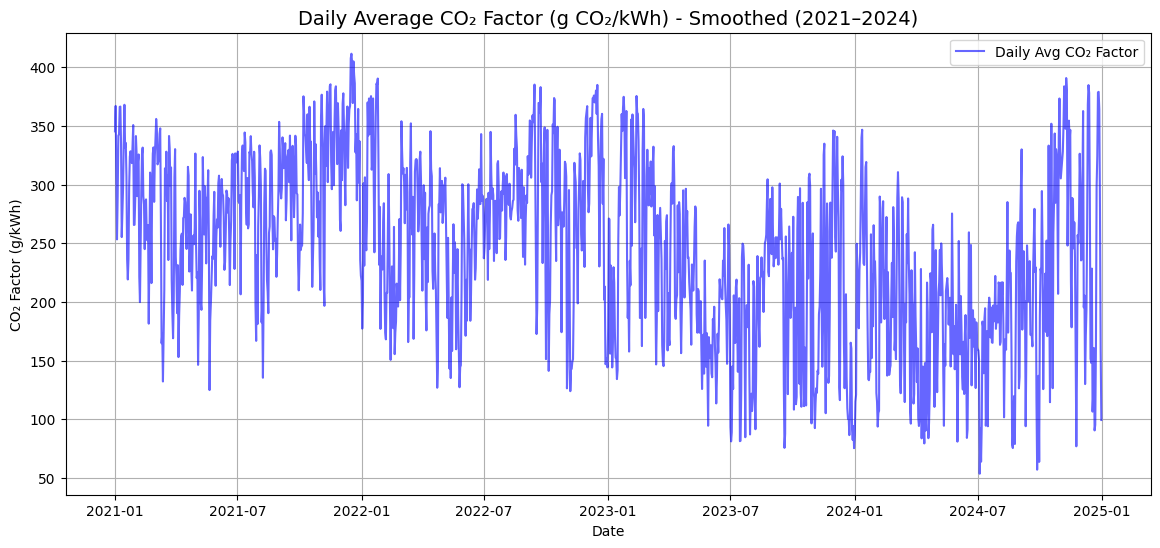

In [8]:
# Convert CO2_factor to g/kWh (better readability)
final_df['CO2_factor_g'] = final_df['CO2_factor'] * 1000  # g/kWh

# Resample to daily averages
daily_factor = final_df.resample('D', on='datetime')['CO2_factor_g'].mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_factor, color='blue', alpha=0.6, label='Daily Avg CO₂ Factor')
plt.title('Daily Average CO₂ Factor (g CO₂/kWh) - Smoothed (2021–2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('CO₂ Factor (g/kWh)')
plt.legend()
plt.grid(True)
plt.show()


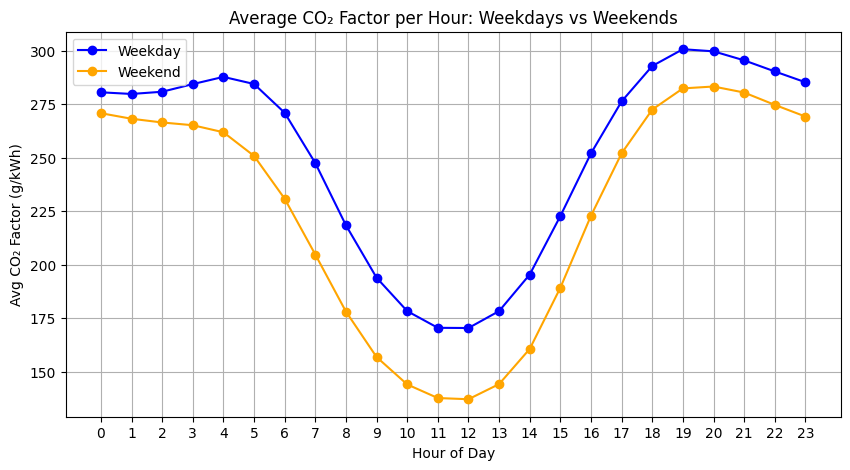

In [9]:
# WEEKDAY VS WEEKEND HOURLY CYCLE
final_df['is_weekend'] = final_df['datetime'].dt.weekday >= 5
weekday_profile = final_df[~final_df['is_weekend']].groupby('hour')['CO2_factor_g'].mean()
weekend_profile = final_df[final_df['is_weekend']].groupby('hour')['CO2_factor_g'].mean()

plt.figure(figsize=(10, 5))
plt.plot(weekday_profile, label='Weekday', marker='o', color='blue')
plt.plot(weekend_profile, label='Weekend', marker='o', color='orange')
plt.title('Average CO₂ Factor per Hour: Weekdays vs Weekends')
plt.xlabel('Hour of Day')
plt.ylabel('Avg CO₂ Factor (g/kWh)')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

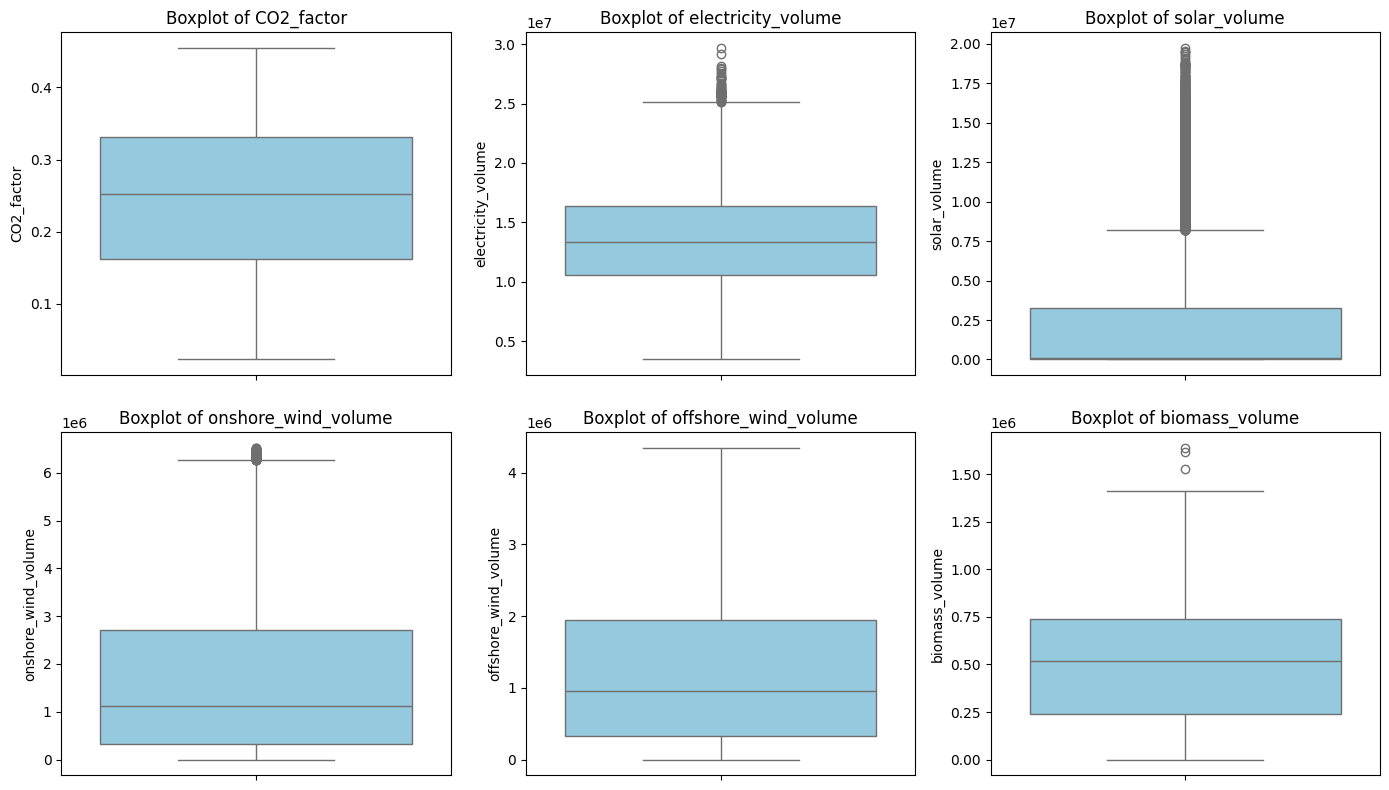

CO2_factor: 0 outliers detected (IQR bounds: -0.09 - 0.59)
electricity_volume: 63 outliers detected (IQR bounds: 1837798.50 - 25117758.50)
solar_volume: 3049 outliers detected (IQR bounds: -4908082.50 - 8180137.50)
onshore_wind_volume: 94 outliers detected (IQR bounds: -3232581.75 - 6263644.25)
offshore_wind_volume: 0 outliers detected (IQR bounds: -2096501.25 - 4381500.75)
biomass_volume: 3 outliers detected (IQR bounds: -509689.75 - 1492176.25)


,datetime,electricity_volume,CO2_emission,CO2_factor,solar_volume,onshore_wind_volume,offshore_wind_volume,biomass_volume,temp,wind_speed,...,cloud_cover,year,month,day,day_of_week,hour,hour_sin,hour_cos,CO2_factor_g,is_weekend


In [10]:
# List of variables to check
numeric_cols = ['CO2_factor', 'electricity_volume', 'solar_volume',
                'onshore_wind_volume', 'offshore_wind_volume', 'biomass_volume']

# . Boxplots for each variable
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=final_df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# 2. Detect outliers using IQR method
outlier_summary = {}
for col in numeric_cols:
    Q1 = final_df[col].quantile(0.25)
    Q3 = final_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = final_df[(final_df[col] < lower_bound) | (final_df[col] > upper_bound)]
    outlier_summary[col] = len(outliers)

    print(f"{col}: {len(outliers)} outliers detected (IQR bounds: {lower_bound:.2f} - {upper_bound:.2f})")

# Display a few outlier rows for a variable (e.g., CO2_factor)
display(final_df[(final_df['CO2_factor'] > upper_bound) | (final_df['CO2_factor'] < lower_bound)].head())

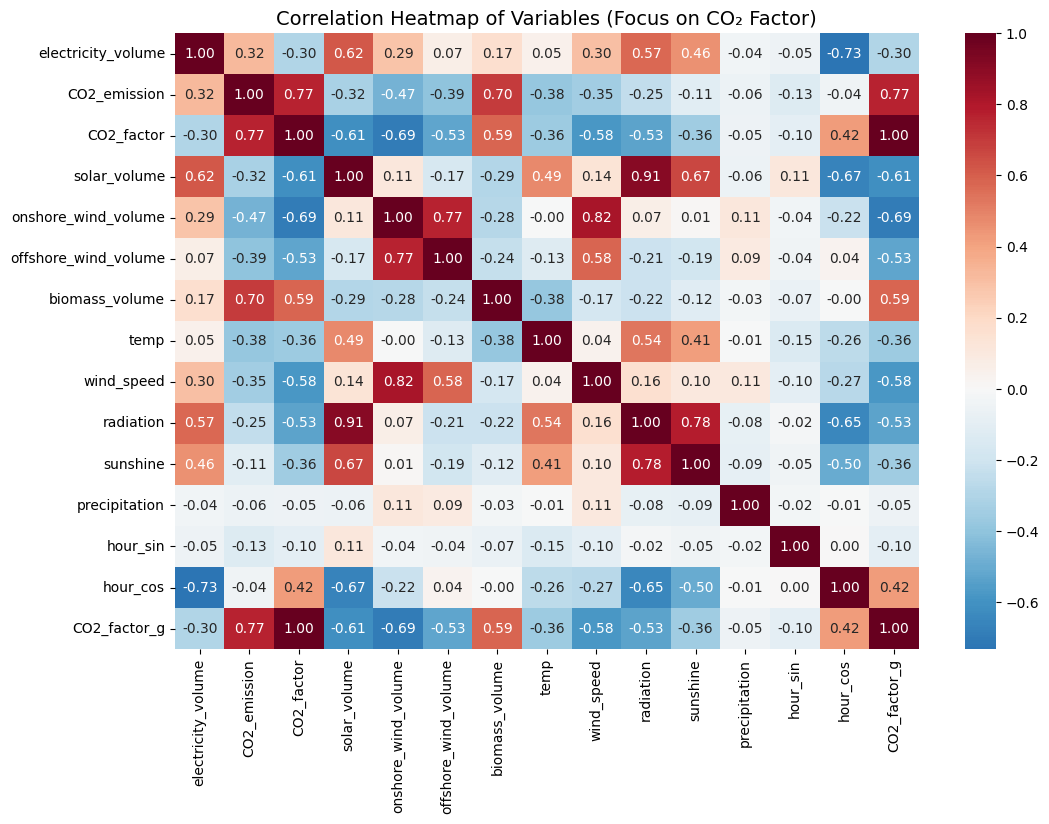

In [11]:
# Select the variables
numeric_cols = final_df.select_dtypes(include=['float64', 'int64']).columns
#remove unecessary columns
model_features = final_df.drop(columns=['CO2_emission', 'CO2_factor_g'])

plt.figure(figsize=(12, 8))
corr = final_df[numeric_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",  # Blue = positive, Red = negative correlation
    center=0
)
plt.title("Correlation Heatmap of Variables (Focus on CO₂ Factor)", fontsize=14)
plt.show()

In [12]:
#StepWise Regression

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels OLS
    """
    included = list(initial_list)
    while True:
        changed = False

        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            # Ensure the current subset of X is numeric
            X_subset = sm.add_constant(pd.DataFrame(X[included + [new_column]]).select_dtypes(include=np.number))
            model = sm.OLS(y, X_subset).fit()
            new_pval[new_column] = model.pvalues[new_column]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f'Add  {best_feature:30} with p-value {best_pval:.6}')

        # backward step
        # Ensure the current subset of X is numeric
        X_subset = sm.add_constant(pd.DataFrame(X[included]).select_dtypes(include=np.number))
        model = sm.OLS(y, X_subset).fit()
        # Exclude intercept p-value and handle case where only constant is included
        if 'const' in model.pvalues.index and len(model.pvalues) > 1:
             pvalues = model.pvalues.drop('const')
        elif 'const' not in model.pvalues.index and len(model.pvalues) > 0:
             pvalues = model.pvalues
        else:
            pvalues = pd.Series(dtype=float) # Empty series if only constant or no features

        if not pvalues.empty:
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f'Drop {worst_feature:30} with p-value {worst_pval:.6}')


        if not changed:
            break
    return included



# Select x variables
numeric_features = final_df.select_dtypes(include=np.number).drop(columns=['CO2_factor', 'CO2_emission', 'CO2_factor_g', 'hour', 'day' ])
features = numeric_features.copy() # Use numeric features

target = final_df['CO2_factor']

# Run Stepwise Regression
selected_features = stepwise_selection(features, target)
print("Selected Features:", selected_features)

Add  wind_speed                     with p-value 0.0
Add  offshore_wind_volume           with p-value 0.0
Add  sunshine                       with p-value 0.0
Add  solar_volume                   with p-value 0.0
Add  day_of_week                    with p-value 0.0
Add  onshore_wind_volume            with p-value 0.0
Drop sunshine                       with p-value 0.497625
Add  electricity_volume             with p-value 0.0
Add  month                          with p-value 0.0
Add  biomass_volume                 with p-value 0.0
Add  hour_cos                       with p-value 0.0
Drop day_of_week                    with p-value 0.687493
Add  radiation                      with p-value 4.41096e-80
Add  hour_sin                       with p-value 8.39798e-114
Add  precipitation                  with p-value 9.19509e-10
Add  sunshine                       with p-value 6.56923e-09
Add  temp                           with p-value 3.14555e-05
Add  day_of_week                    with p-value

In [13]:
#with all variables
# Define X and y
X = final_df.select_dtypes(include=np.number).drop(
    columns=['CO2_factor', 'CO2_emission', 'CO2_factor_g'], errors='ignore'
)
y = final_df['CO2_factor']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the model
ols_model = LinearRegression() # Define ols_model
ols_model.fit(X_train, y_train)

# Predictions
y_train_pred = ols_model.predict(X_train)
y_test_pred = ols_model.predict(X_test)

# Metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

cv_rmse = -cross_val_score(ols_model, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()

# Print results
print(f"Train -> RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"Test  -> RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")
print(f"Cross-Validation RMSE (mean): {cv_rmse:.4f}")

Train -> RMSE: 0.0267, MAE: 0.0209, R²: 0.9220
Test  -> RMSE: 0.0326, MAE: 0.0256, R²: 0.9132
Cross-Validation RMSE (mean): 0.0310


In [14]:
#check for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the dataset (X) with the 14 features
X_vif = final_df[['solar_volume', 'onshore_wind_volume', 'electricity_volume',
                  'offshore_wind_volume', 'hour_cos', 'biomass_volume', 'month',
                  'radiation', 'hour_sin', 'wind_speed', 'precipitation',
                  'sunshine', 'temp', 'day_of_week']].copy()

# Add a constant (required for VIF)
X_vif_const = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X_vif_const.columns
vif['VIF'] = [variance_inflation_factor(X_vif_const.values, i)
                   for i in range(X_vif_const.shape[1])]

print(vif)


                 Feature        VIF
0                  const  68.115650
1           solar_volume   9.215802
2    onshore_wind_volume   5.877804
3     electricity_volume   4.180805
4   offshore_wind_volume   3.137038
5               hour_cos   2.866244
6         biomass_volume   1.917574
7                  month   1.125431
8              radiation   9.726418
9               hour_sin   1.222911
10            wind_speed   3.516554
11         precipitation   1.034126
12              sunshine   2.631160
13                  temp   2.007845
14           day_of_week   1.169173


"radiation" has a high VIF and it is also highly correlated with 'solar_volume", so it was removed. Also, the 'wind_speed' was moderately correlated with "onshore_wind_volme", which has a VIF >5 (but couldd not be removed because its an important factor), so to eliminate any potential overfitting issue, it was removed. By removing these features there are no multicollinearity issues since the VIF <5 for all the products.


In [16]:
#VIF Check without radiation and wind_speed
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the dataset (X) with the final features
X_vif = final_df[['solar_volume', 'onshore_wind_volume', 'electricity_volume',
                  'offshore_wind_volume', 'hour_cos', 'biomass_volume', 'month',
                  'hour_sin', 'precipitation',
                  'sunshine', 'temp', 'day_of_week']].copy()

# Add a constant (required for VIF)
X_vif_const = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X_vif_const.columns
vif['VIF'] = [variance_inflation_factor(X_vif_const.values, i)
                   for i in range(X_vif_const.shape[1])]

print(vif)

                 Feature        VIF
0                  const  64.065837
1           solar_volume   4.593525
2    onshore_wind_volume   3.163555
3     electricity_volume   4.157749
4   offshore_wind_volume   3.094073
5               hour_cos   2.813470
6         biomass_volume   1.884737
7                  month   1.088682
8               hour_sin   1.175812
9          precipitation   1.029164
10              sunshine   1.958221
11                  temp   1.929168
12           day_of_week   1.168553


In [17]:
# OLS, Lasso and Ridge

# Data Preparation

features_12 = ['solar_volume', 'onshore_wind_volume', 'electricity_volume',
               'offshore_wind_volume', 'hour_cos', 'biomass_volume',
               'month', 'sunshine', 'hour_sin', 'wind_speed', 'temp',
               'precipitation']

X = final_df[features_12]
y = final_df['CO2_factor']

# 80/20 Train-Test Split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Models to Evaluate
models = {
    "OLS (Linear Regression)": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001)
}


# Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_rmse, train_mae, train_r2, test_rmse, test_mae, test_r2


# Run Models + Cross-Validation
results = []

tscv = TimeSeriesSplit(n_splits=5)

for name, model in models.items():
    # Train/Test metrics
    train_rmse, train_mae, train_r2, test_rmse, test_mae, test_r2 = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Cross-validation
    cv_rmse, cv_mae, cv_r2 = [], [], []
    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_t, y_t)
        y_val_pred = model.predict(X_val)
        cv_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        cv_mae.append(mean_absolute_error(y_val, y_val_pred))
        cv_r2.append(r2_score(y_val, y_val_pred))

    results.append({
        "Model": name,
        "RMSE (train)": train_rmse,
        "MAE (train)": train_mae,
        "R² (train)": train_r2,
        "RMSE (test)": test_rmse,
        "MAE (test)": test_mae,
        "R² (test)": test_r2,
        "CV RMSE (mean)": np.mean(cv_rmse)
    })


# Display Results

results_df = pd.DataFrame(results)
print(results_df)

                     Model  RMSE (train)  MAE (train)  R² (train)  \
0  OLS (Linear Regression)      0.026834     0.021024    0.921002   
1                    Ridge      0.026834     0.021024    0.921002   
2                    Lasso      0.027084     0.021153    0.919524   

   RMSE (test)  MAE (test)  R² (test)  CV RMSE (mean)  
0     0.032875    0.025510   0.911887        0.033592  
1     0.032875    0.025510   0.911884        0.033591  
2     0.034341    0.026279   0.903849        0.033644  


In [18]:
# Initialize models
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Function to evaluate models (same as before)
def evaluate_model_cv(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Cross-validation
    cv_rmse, cv_mae, cv_r2 = [], [], []
    for train_idx, val_idx in TimeSeriesSplit(n_splits=5).split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_t, y_t)
        y_val_pred = model.predict(X_val)
        cv_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        cv_mae.append(mean_absolute_error(y_val, y_val_pred))
        cv_r2.append(r2_score(y_val, y_val_pred))

    return {
        "RMSE (train)": train_rmse,
        "MAE (train)": train_mae,
        "R² (train)": train_r2,
        "RMSE (test)": test_rmse,
        "MAE (test)": test_mae,
        "R² (test)": test_r2,
        "CV RMSE (mean)": np.mean(cv_rmse)
    }

# Evaluate RF and XGB
rf_results = evaluate_model_cv(rf_model, X_train, y_train, X_test, y_test)
xgb_results = evaluate_model_cv(xgb_model, X_train, y_train, X_test, y_test)

# Append to results table
results_df = pd.DataFrame([
    {
        "Model": "Random Forest",
        **rf_results
    },
    {
        "Model": "XGBoost",
        **xgb_results
    }
])

print(results_df)

           Model  RMSE (train)  MAE (train)  R² (train)  RMSE (test)  \
0  Random Forest      0.005096     0.003700    0.997151     0.018616   
1        XGBoost      0.010418     0.007544    0.988094     0.016364   

   MAE (test)  R² (test)  CV RMSE (mean)  
0    0.014465   0.971745        0.029555  
1    0.012863   0.978167        0.026598  


Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}

Tuned XGBoost Results:
  Train -> RMSE: 0.0132, MAE: 0.0098, R²: 0.9808
  Test  -> RMSE: 0.0145, MAE: 0.0112, R²: 0.9829
  Cross-Validation -> RMSE: 0.0208, MAE: 0.0165, R²: 0.9457


/tmp/ipython-input-20-1260473168.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


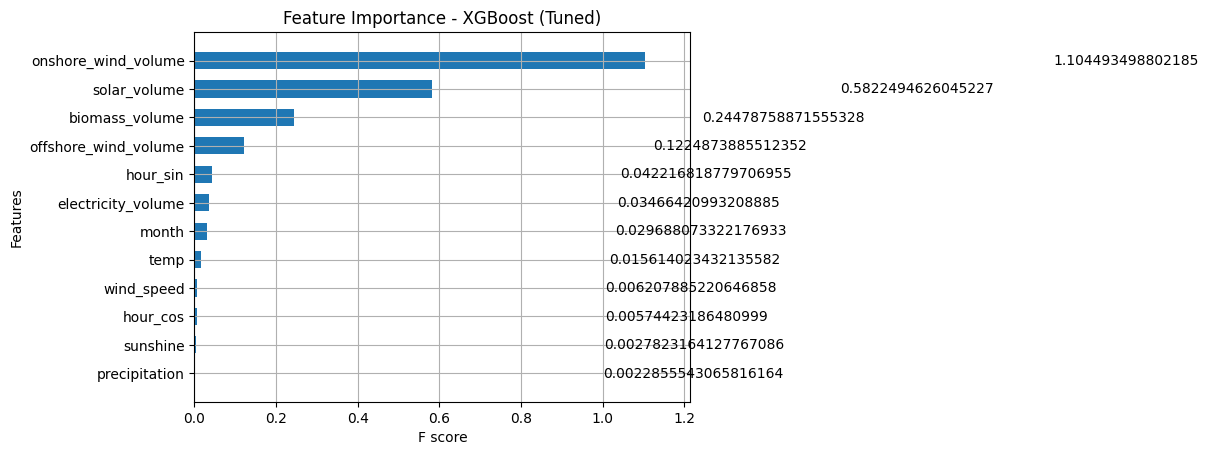

In [20]:
# Hyperparameter Tuning
xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgb_grid.best_params_)

xgb_best = xgb_grid.best_estimator_


# 2. Evaluation Metrics
# Train & Test Predictions
y_train_pred_best = xgb_best.predict(X_train)
y_test_pred_best = xgb_best.predict(X_test)

# Train Metrics
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
mae_train_best = mean_absolute_error(y_train, y_train_pred_best)
r2_train_best = r2_score(y_train, y_train_pred_best)

# Test Metrics
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
mae_test_best = mean_absolute_error(y_test, y_test_pred_best)
r2_test_best = r2_score(y_test, y_test_pred_best)

# Cross-Validation (5-Fold)
cv_rmse = -cross_val_score(xgb_best, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()
cv_mae = -cross_val_score(xgb_best, X, y, cv=5, scoring="neg_mean_absolute_error").mean()
cv_r2 = cross_val_score(xgb_best, X, y, cv=5, scoring="r2").mean()

# Print Metrics
print("\nTuned XGBoost Results:")
print(f"  Train -> RMSE: {rmse_train_best:.4f}, MAE: {mae_train_best:.4f}, R²: {r2_train_best:.4f}")
print(f"  Test  -> RMSE: {rmse_test_best:.4f}, MAE: {mae_test_best:.4f}, R²: {r2_test_best:.4f}")
print(f"  Cross-Validation -> RMSE: {cv_rmse:.4f}, MAE: {cv_mae:.4f}, R²: {cv_r2:.4f}")

In [21]:
#Prepare Data
# Define features and target (using selected features from stepwise regression)
features = ['solar_volume', 'onshore_wind_volume', 'electricity_volume',
            'offshore_wind_volume', 'hour_cos', 'biomass_volume',
            'month', 'sunshine', 'hour_sin', 'wind_speed',
            'temp', 'precipitation']

X = final_df[features]
y = final_df['CO2_factor']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Train LightGBM Model
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)

# Predictions
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

# Metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Cross-validation (5-fold)
cv = KFold(n_splits=5, shuffle=False)
cv_rmse = -cross_val_score(lgb_model, X, y, scoring="neg_root_mean_squared_error", cv=cv).mean()

# Create result table
lgb_result = pd.DataFrame([{
    "Model": "LightGBM",
    "RMSE (train)": rmse_train,
    "MAE (train)": mae_train,
    "R² (train)": r2_train,
    "RMSE (test)": rmse_test,
    "MAE (test)": mae_test,
    "R² (test)": r2_test,
    "CV RMSE (mean)": cv_rmse
}])

# Use print to display the dataframe instead of ace_tools
print(lgb_result)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1674
[LightGBM] [Info] Number of data points in the train set: 28050, number of used features: 12
[LightGBM] [Info] Start training from score 0.254893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1673
[LightGBM] [Info] Number of data points in the train set: 28050, number of used features: 12
[LightGBM] [Info] Start training from score 0.235147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [22]:
X = final_df[selected_features]
y = final_df['CO2_factor']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scale features for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLP
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                   solver='adam', max_iter=300, random_state=42)

# Train on train set
mlp.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = mlp.predict(X_train_scaled)
y_pred_test = mlp.predict(X_test_scaled)

# Metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = np.mean(np.sqrt(-cross_val_score(mlp, X_train_scaled, y_train,
                                          scoring='neg_mean_squared_error', cv=kf)))

print(f"MLP - Train -> RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"MLP - Test  -> RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")
print(f"MLP - Cross-Validation RMSE: {cv_rmse:.4f}")


MLP - Train -> RMSE: 0.0202, MAE: 0.0157, R²: 0.9552
MLP - Test  -> RMSE: 0.0220, MAE: 0.0168, R²: 0.9604
MLP - Cross-Validation RMSE: 0.0231


In [23]:
# Define X and y

X = final_df[selected_features]
y = final_df['CO2_factor']

# Train-test split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Create Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),          # Standardize features
    ('knn', KNeighborsRegressor())
])


# 3. Hyperparameter Tuning

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters for kNN:", best_params)

# Best model
knn_model = grid_search.best_estimator_

# Predictions

y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)


# Metrics

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

cv_rmse = -cross_val_score(knn_model, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()

print(f"kNN - Train -> RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"kNN - Test  -> RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")
print(f"kNN - Cross-Validation RMSE: {cv_rmse:.4f}")


Best parameters for kNN: {'knn__n_neighbors': 15, 'knn__weights': 'distance'}
kNN - Train -> RMSE: 0.0000, MAE: 0.0000, R²: 1.0000
kNN - Test  -> RMSE: 0.0285, MAE: 0.0225, R²: 0.9336
kNN - Cross-Validation RMSE: 0.0295


In [26]:
# Select Only Relevant Features
selected_features = [
    'solar_volume', 'onshore_wind_volume', 'electricity_volume',
    'offshore_wind_volume', 'hour_cos', 'biomass_volume',
    'month', 'hour_sin', 'precipitation', 'sunshine', 'temp', 'day_of_week'
]

X = final_df[selected_features]
y = final_df['CO2_factor']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Set float display format
pd.options.display.float_format = '{:.4f}'.format


# Helper function
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Cross-validation (5-fold)
    cv_rmse = -cross_val_score(model, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()

    return {
        "Model": model_name,
        "RMSE (train)": rmse_train,
        "MAE (train)": mae_train,
        "R² (train)": r2_train,
        "RMSE (test)": rmse_test,
        "MAE (test)": mae_test,
        "R² (test)": r2_test,
        "CV RMSE (mean)": cv_rmse
    }


# Create Models
models = [
    (LinearRegression(), "OLS (Linear Regression)"),
    (Ridge(alpha=1.0), "Ridge"),
    (Lasso(alpha=0.001), "Lasso"),
    (RandomForestRegressor(n_estimators=300, random_state=42), "Random Forest"),
    (XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42), "XGBoost (untuned)"),
    (xgb_best, "XGBoost (tuned)"),  # Use your tuned XGBoost
    (LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42), "LightGBM"),
    (KNeighborsRegressor(n_neighbors=5), "KNN")
]

# Evaluate Models

metrics_list = []
for model, name in models:
    metrics_list.append(evaluate_model(model, name, X_train, y_train, X_test, y_test))


# Create Metrics Table
metrics_table = pd.DataFrame(metrics_list)
print(metrics_table)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 28050, number of used features: 12
[LightGBM] [Info] Start training from score 0.254893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 28050, number of used features: 12
[LightGBM] [Info] Start training from score 0.235147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

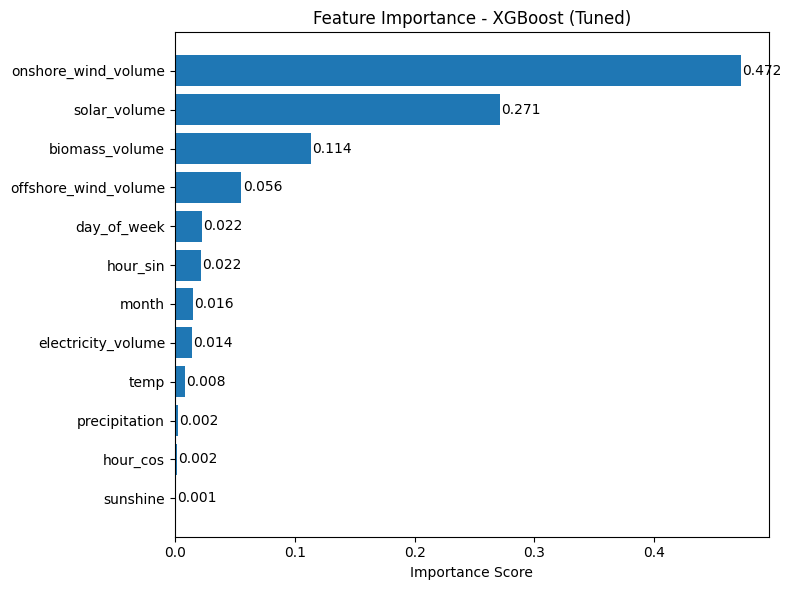

In [28]:
#Get feature importance values
importance_vals = xgb_best.feature_importances_
features = X_train.columns

# Sort by importance
sorted_idx = np.argsort(importance_vals)
sorted_features = features[sorted_idx]
sorted_importance = importance_vals[sorted_idx]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(sorted_features, sorted_importance)
plt.title("Feature Importance - XGBoost (Tuned)")

# Add text labels with 3 decimals
for bar, value in zip(bars, sorted_importance):
    plt.text(value + 0.001, bar.get_y() + bar.get_height()/2, f"{value:.3f}", va='center')

plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


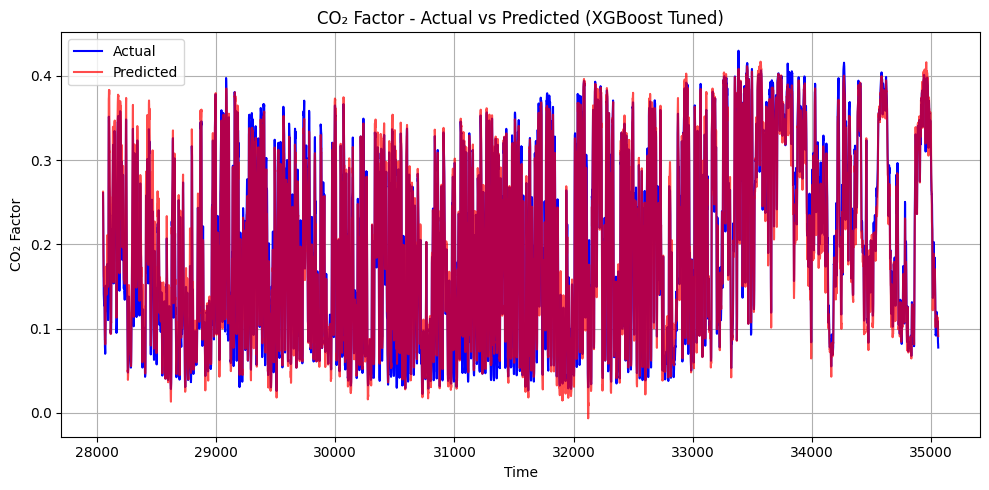

In [33]:
# Get predictions for the test set
y_test_pred = xgb_best.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', alpha=0.7)
plt.title("CO₂ Factor - Actual vs Predicted (XGBoost Tuned)")
plt.xlabel("Time")
plt.ylabel("CO₂ Factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

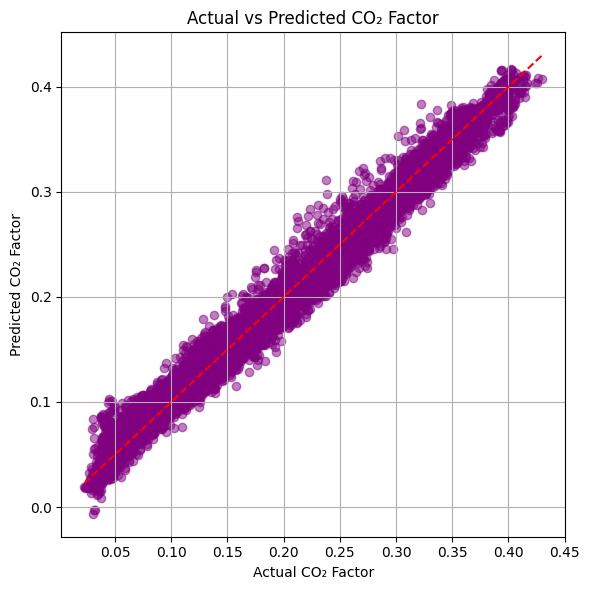

In [34]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.title("Actual vs Predicted CO₂ Factor")
plt.xlabel("Actual CO₂ Factor")
plt.ylabel("Predicted CO₂ Factor")
plt.grid(True)
plt.tight_layout()
plt.show()

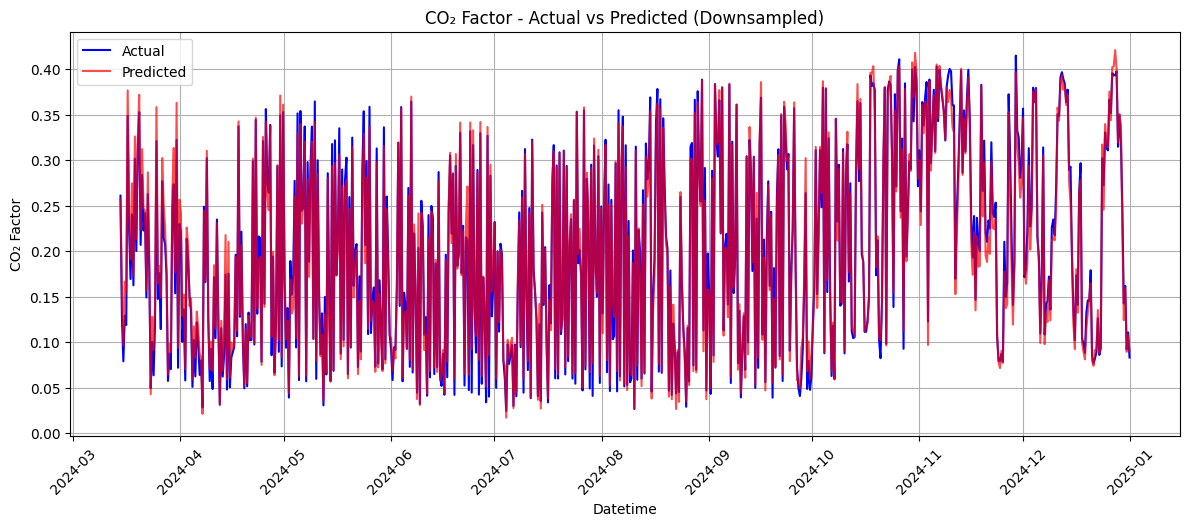

In [37]:
# Downsample for time series plot
if 'datetime' in final_df.columns:
    y_test = y_test.copy()
    y_test.index = final_df.loc[y_test.index, 'datetime']
#create the plot
step = 10  # take 1 out of every 10 points
plt.figure(figsize=(12, 5))
plt.plot(y_test.index[::step], y_test.values[::step], label="Actual", color="blue")
plt.plot(y_test.index[::step], y_test_pred_xgb_best[::step], label="Predicted", color="red", alpha=0.7)
plt.title("CO₂ Factor - Actual vs Predicted (Downsampled)")
plt.xlabel("Datetime")  # Change label
plt.ylabel("CO₂ Factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate for better readability
plt.show()



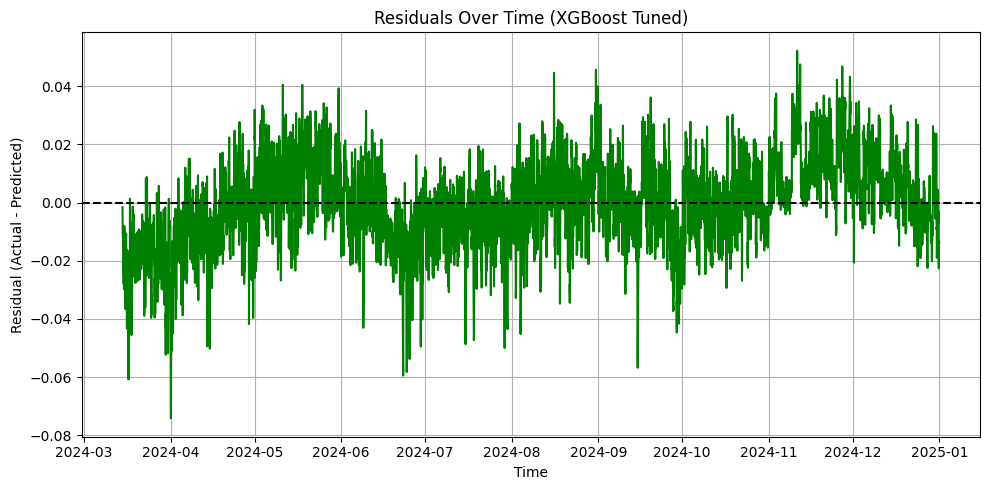

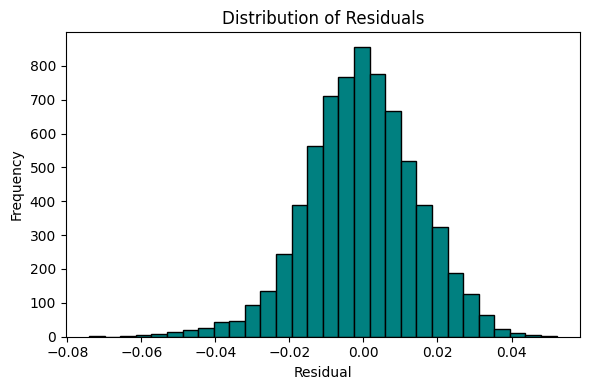

In [38]:
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, residuals, color='green')
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals Over Time (XGBoost Tuned)")
plt.xlabel("Time")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='teal', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


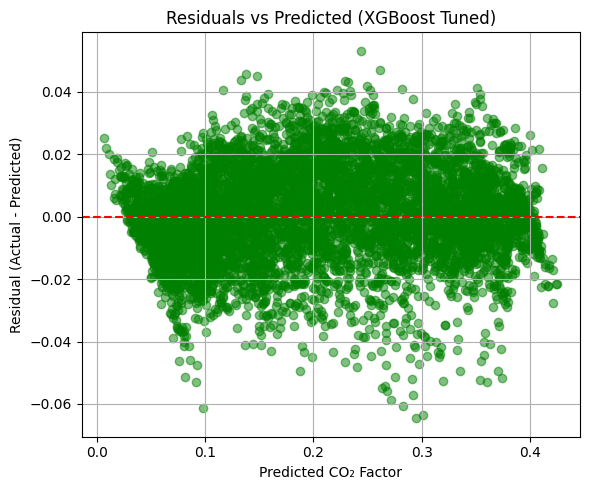

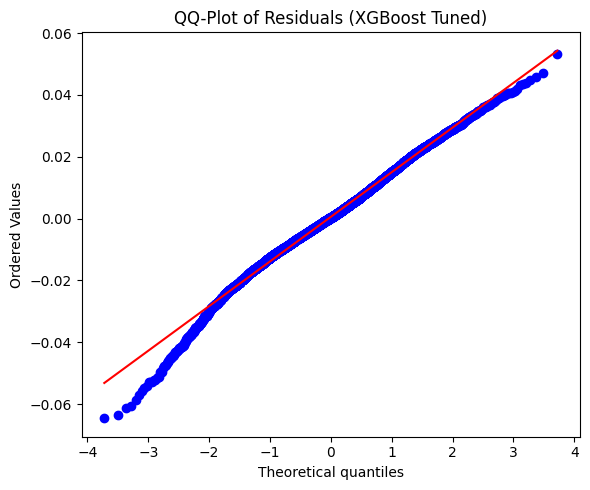

In [40]:
# QQ-Plot

plt.figure(figsize=(6, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals (XGBoost Tuned)")
plt.tight_layout()
plt.show()


In [32]:
# Save model
joblib.dump(xgb_best, "xgboost_tuned_model.pkl")

['xgboost_tuned_model.pkl']